# 1. ALS
- **정의**  
기존의 SGD가 두 개의 행렬(User Latent, Item Latent)을 동시에 최적화하는 방법이라면, ALS는 두 행렬 중 하나를 고정시키고 다른 하나의 행렬을 순차적으로 반복하면서 최적화하는 방법이다. 이렇게 하면, 기존의 최적화 문제가 convex 형태로 바뀌기에 수렴된 행렬을 찾을 수 있는 장점이 있다. 학습에 진행되는 알고리즘은 아래의 4개 과정이 순차적으로 진행되면서 User Latent와 Item Latent를 찾게 된다.

- **알고리즘**  
    1. 초기 아이템, 사용자 행렬을 초기화
    2. 아이템 행렬을 고정하고 사용자 행렬을 최적화
    3. 사용자 행렬을 고정하고 아이템 행렬을 최적화
    4. 위의 2, 3 과정을 반복

- **수렴**  
기존의 SGD가 두 개의 행렬(User Latet, Item Latent)을 동시에 최적화하는 방법이라면, ALS는 두 행렬 중 하나를 고정시키고 다른 하나의 행렬을 순차적으로 반복하면서 최적화하는 방법이다. 이렇게 하면, 기존의 최적화 문제가 convex 형태로 바뀌기에 수렴된 행렬을 찾을 수 있는 장점이 있다.
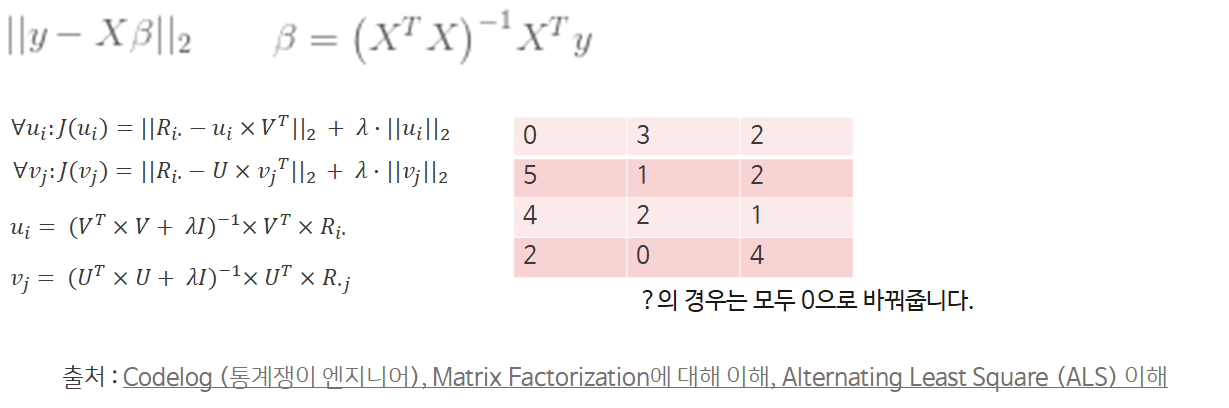

---

먼저, 초기 아이템, 사용자 행렬을 초기화해주는 과정은 SGD와 동일하다.  
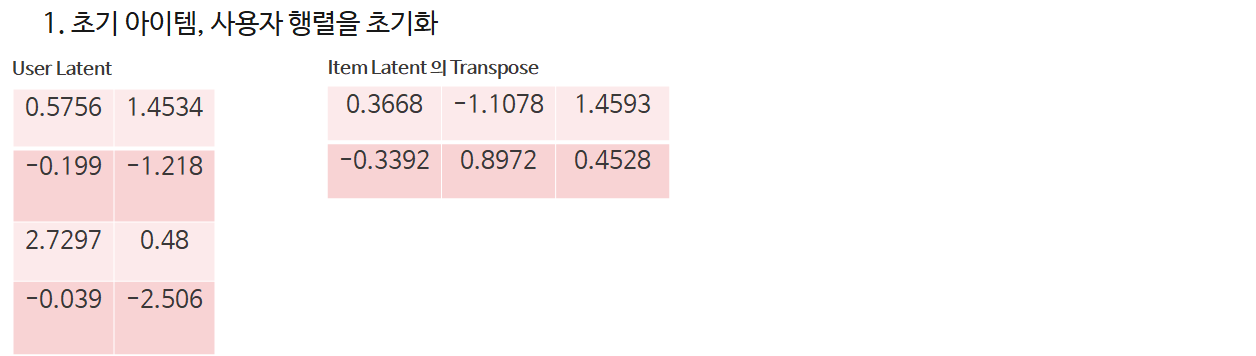

이후에 아이템 행렬을 고정하고 사용자 행렬을 최적화한다. SGD에서는 아이템 행렬을 고정하지 않고 동시에 아이템과 사용자 행렬을 최적화한 반면에, ALS는 하나의 행렬의 수렴을 끝내고 다른 하나의 행렬의 수렴을 진행한다는 점에서 가장 큰 차이를 보인다.  
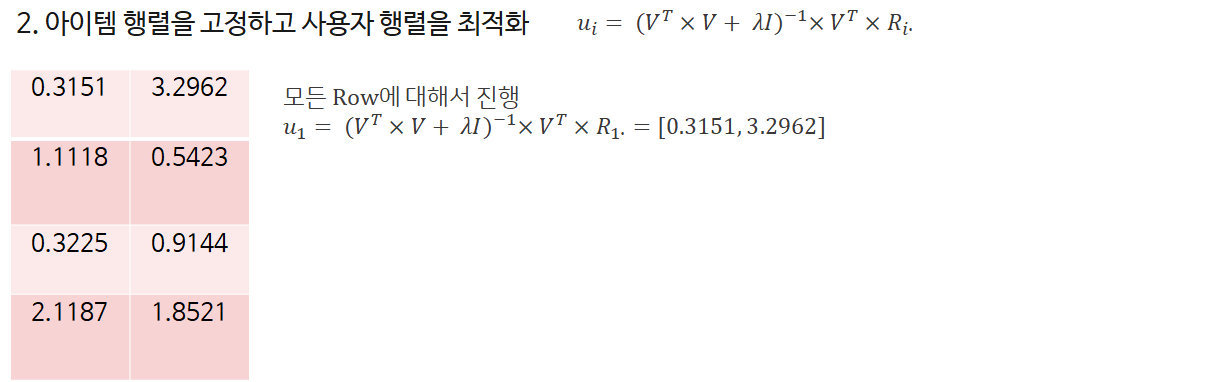

마찬가지로, 이제 사용자 행렬을 고정하고 아이템 행렬을 최적화해준다.  
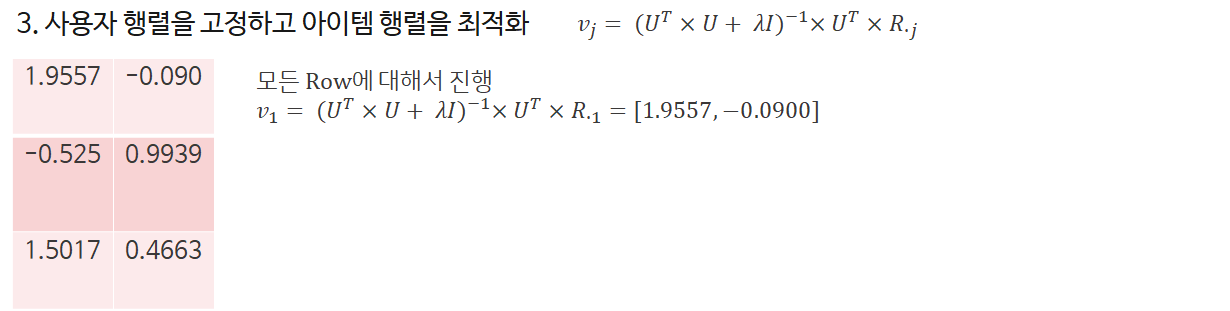

보통 이런 식의 반복되는 최적화 과정을 거치면, 아이템 행렬의 값이 달라져서 사용자 행렬의 최적화된 값도 달라진다. 그렇기에, 해당 과정을 반복해가면서 두 행렬 모두 수렴의 근접한 값을 찾아주는게 ALS 알고리즘의 핵심이다.

---

## 1.1 협업 필터링 - 장단점
1. 장점
    - 도메인 지식이 필요하지 않음
    - 사용자의 새로운 흥미를 발견하기 좋음
    - 시작단계의 모델로 선택하기 좋음 (추가적인 문맥정보등의 필요가 없음)
2. 단점
    - 새로운 아이템에 대해서 다루기가 힘듦
    - side features(고객의 개인정보, 아이템의 추가정보)를 포함시키기 어려움

---

## 1.2 ALS - 장단점
1. 장점
    - SGD보다 수렴속도가 빠름
    - parallelized가 가능함
2. 단점
    - 오직 Loss Squares만 사용 가능

---

## 1.3 ALS - 구현

In [1]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

# Base code : https://github.com/mickeykedia/Matrix-Factorization-ALS/blob/master/ALS%20Python%20Implementation.py
class AlternatingLeastSquares():
    def __init__(self, R, k, reg_param, epochs, verbose=False):
        """
        :param R: rating matrix
        :param k: latent parameter
        :param learning_rate: alpha on weight update
        :param reg_param: beta on weight update
        :param epochs: training epochs
        :param verbose: print status
        """
        self._R = R
        self._num_users, self._num_items = R.shape
        self._k = k
        self._reg_param = reg_param
        self._epochs = epochs
        self._verbose = verbose


    def fit(self):
        # init latent features
        self._users = np.random.normal(size=(self._num_users, self._k))
        self._items = np.random.normal(size=(self._num_items, self._k))

        # train while epochs
        self._training_process = []
        self._user_error = 0; self._item_error = 0; 
        for epoch in range(self._epochs):
            for i, Ri in enumerate(self._R):
                self._users[i] = self.user_latent(i, Ri)
                self._user_error = self.cost()

            for j, Rj in enumerate(self._R.T):
                self._items[j] = self.item_latent(j, Rj)
                self._item_error = self.cost()

            cost = self.cost()
            self._training_process.append((epoch, cost))

            # print status
            if self._verbose == True and ((epoch + 1) % 10 == 0):
                print("Iteration: %d ; cost = %.4f" % (epoch + 1, cost))


    def cost(self):
        """
        compute root mean square error
        :return: rmse cost
        """
        xi, yi = self._R.nonzero()
        cost = 0
        for x, y in zip(xi, yi):
            cost += pow(self._R[x, y] - self.get_prediction(x, y), 2)
        return np.sqrt(cost/len(xi))


    def user_latent(self, i, Ri):
        """
        :param error: rating - prediction error
        :param i: user index
        :param Ri: Rating of user index i
        :return: convergence value of user latent of i index
        """

        du = np.linalg.solve(np.dot(self._items.T, np.dot(np.diag(Ri), self._items)) + self._reg_param * np.eye(self._k),
                                   np.dot(self._items.T, np.dot(np.diag(Ri), self._R[i].T))).T
        return du

    def item_latent(self, j, Rj):
        """
        :param error: rating - prediction error
        :param j: item index
        :param Rj: Rating of item index j
        :return: convergence value of itemr latent of j index
        """

        di = np.linalg.solve(np.dot(self._users.T, np.dot(np.diag(Rj), self._users)) + self._reg_param * np.eye(self._k),
                                 np.dot(self._users.T, np.dot(np.diag(Rj), self._R[:, j])))
        return di


    def get_prediction(self, i, j):
        """
        get predicted rating: user_i, item_j
        :return: prediction of r_ij
        """
        return self._users[i, :].dot(self._items[j, :].T)


    def get_complete_matrix(self):
        """
        :return: complete matrix R^
        """
        return self._users.dot(self._items.T)



# run example
if __name__ == "__main__":
    # rating matrix - User X Item : (7 X 5)
    R = np.array([
        [1, 0, 0, 1, 3],
        [2, 0, 3, 1, 1],
        [1, 2, 0, 5, 0],
        [1, 0, 0, 4, 4],
        [2, 1, 5, 4, 0],
        [5, 1, 5, 4, 0],
        [0, 0, 0, 1, 0],
    ])

In [2]:
als = AlternatingLeastSquares(R = R, reg_param = 0.01, epochs=100, verbose=True, k=3)
als.fit()

Iteration: 10 ; cost = 0.1516
Iteration: 20 ; cost = 0.0416
Iteration: 30 ; cost = 0.0207
Iteration: 40 ; cost = 0.0175
Iteration: 50 ; cost = 0.0157
Iteration: 60 ; cost = 0.0143
Iteration: 70 ; cost = 0.0132
Iteration: 80 ; cost = 0.0123
Iteration: 90 ; cost = 0.0116
Iteration: 100 ; cost = 0.0110


In [3]:
als.get_complete_matrix()

array([[ 1.00725568, -0.42763642, -1.9868349 ,  1.00554551,  2.99089663],
       [ 2.00641614,  0.61178487,  2.99041164,  1.03418777,  0.97111531],
       [ 1.00766436,  1.99856069,  9.78290741,  4.9990081 ,  2.05594927],
       [ 1.01211197,  0.72080265,  3.63432193,  4.00443837,  4.00246906],
       [ 1.99950517,  1.00408234,  4.99777829,  3.99818468,  3.85105394],
       [ 4.99393797,  0.99845349,  5.00265543,  3.99589205,  5.61045268],
       [ 1.26688459,  0.30350101,  1.50803391,  0.99347727,  1.269262  ]])